### Scraping data from various sites (and saving to csv) ...

In [2]:
from bs4 import BeautifulSoup
import urllib
import pandas as pd
import numpy as np
import nflgame
import os
import seaborn as sns
import matplotlib.pyplot as plt

#Custom color palettes for graphs
custompal = ["#F44336","#E91E63","#9C27B0","#673AB7","#3F51B5","#2196F3","#03A9F4","#00BCD4","#009688","#4CAF50",
             "#8BC34A","#CDDC39","#FFEB3B","#FFC107","#FF9800","#FF5722","#795548","#9E9E9E","#607D8B"]
minicustom = custompal[::2]
sns.set_palette(minicustom)
#sns.palplot(custompal)

sns.set_style("whitegrid")
sns.set_context("notebook")
plt.figure(figsize=(16, 8))

#Setting for displaying inline graphics with matplotlib
%matplotlib inline


sns.set_style("whitegrid")
sns.set_context("notebook")
plt.figure(figsize=(16, 8))
teams = ['buffalo-bills', 'miami-dolphins', 'new-england-patriots', 'new-york-jets', 'baltimore-ravens',
         'cincinnati-bengals', 'cleveland-browns', 'pittsburgh-steelers', 'houston-texans', 'indianapolis-colts',
         'jacksonville-jaguars', 'tennessee-titans', 'denver-broncos', 'kansas-city-chiefs', 'oakland-raiders',
         'san-diego-chargers', 'dallas-cowboys', 'new-york-giants', 'philadelphia-eagles', 'washington-redskins',
         'chicago-bears', 'detroit-lions', 'green-bay-packers', 'minnesota-vikings', 'atlanta-falcons',
         'carolina-panthers', 'new-orleans-saints', 'tampa-bay-buccaneers', 'arizona-cardinals',
         'san-francisco-49ers', 'seattle-seahawks', 'st-louis-rams']

def GetStdTeam(team):
    #Convert team name into easily parsable string
    tm = team.replace('-',' ')

    #Rams no longer in St. Louis (so just use Rams for search)
    if ("rams" in tm):
        tm = "rams"

    #Get standard team name
    stdteam = nflgame.standard_team(str(tm))
    return stdteam


def GetPenaltyData(team, year):
    print 'Getting data for ' + team + ' ' + year

    #Set up url string
    teamfile = 'http://www.nflpenalties.com/team/' + team + '?year=' + year + '&view=log'

    #Set up BeautifulSoup parser
    r = urllib.urlopen(teamfile).read()
    soup = BeautifulSoup(r, "lxml")
    print type(soup)

    #Get content
    content = soup.find_all("div", id="content")

    return content


def ParseContent(content, stdteam):
    tb = content[0].find('tbody')
    y = pd.DataFrame()
    z = ['team','penalty','game','opponent','player','position','week','year','penaltyindex']
    count = 0
    missing = 0

    for row in tb.findAll('tr'):
        missing = str(row).count('></a>')

        if (missing == 0):
            for link in row.findAll('a'):

                href = link['href']
                linkinfo = href.split('/')
                linkcat = str(linkinfo[1])

                linkdetails = str(link.get_text())

                if (linkcat == 'penalty'):
                    t = [stdteam]

                if ('week.php' not in href):
                    t = np.hstack([t, linkdetails])
                else:
                    weekandyear = href.split('week=')[1]
                    week = weekandyear.split('?')[0]
                    year = weekandyear.split('year=')[1]

                    t = np.hstack([t, week, year])

                    penaltyindex = stdteam + '-' + str(year) + '-' + str(count)

                    t = np.hstack([t, penaltyindex])
                    z = np.vstack([z,t])
                    count += 1
        else:
            missing += 1

    totalpenalties = missing + count
    z['opponent'] = z['opponent'].apply(lambda x: GetStdTeam(x))
    return [z,totalpenalties]

#This writes CSV of data for particular team and year
def WritePenaltyData(penalties, stdteam, year, fname):
    totalnumpenalties = penalties[1]
    print stdteam + ',' + year + ',' + str(totalnumpenalties)
    np.savetxt(fname, penalties[0], fmt = '%s', delimiter=',')

#Gets data from all teams into dataframe for particular year
def GetAllTeams(year):
    data = pd.DataFrame()
    for team in teams:
        stdteam = GetStdTeam(team)
        print stdteam
        fname = '/Users/kelly89/NFLPenalties/' + stdteam + year + '.csv'

        if (os.path.isfile(fname) == False):
            content = GetPenaltyData(team, year)
            penalties = ParseContent(content, stdteam)
            WritePenaltyData(penalties, stdteam, year, fname)
        else:
            print 'Found data file for ' + stdteam + ' ' + year

        temp = pd.read_csv(fname, sep = ',')
        data = pd.concat([data,temp], ignore_index = True)
    return data

#Writes main CSV (penalty data fro all teams and all years from 2011-2015)
def GetAllYears(fname):
    alldata = pd.DataFrame()
    for year in ['2011','2012','2013','2014','2015']:
        tempyear = GetAllTeams(year)
        alldata = pd.concat([alldata,tempyear], ignore_index = True)

    alldata.columns = ['Team','Penalty','NDate','Opponent','Player','Position','Week','Year','PenaltyIndex']
    alldata['Opponent'] = alldata['Opponent'].apply(lambda x: GetStdTeam(x))
    d = alldata.dropna()
    d.to_csv(fname, sep = ',', index = False)

def GetRegSeasonRecord (team, year):
    team = str(team)
    year = int(year)

    games = nflgame.games_gen(year, week = None, home = team, away = team, kind = 'REG')
    for g in games:
        print g
        if (g.winner == team):
            w += 1
        elif (g.loser == team):
            l += 1
        else:
            print "ERROR: can not determine winner of this game"

        print 'W-L: ' + str(w) + '-' + str(l)

    return [int(w),int(l)]

def GetAllRefInfo(fname):
    pfr = 'http://www.pro-football-reference.com/officials'
    pfrUrl = urllib.urlopen(pfr).read()
    pfrSoup = BeautifulSoup(pfrUrl, "lxml")
    content = pfrSoup.find_all("div", id="page_content")

    a = content[0].find('table')
    b = pd.DataFrame()
    c = ['webpage','name','games','positions','years']
    count = 0
    m = 0
    e = []

    for row in a.findAll('tr')[1:]:
        m = str(row).count('></td>')
        webpage = os.path.dirname(pfr) + str(row.findNext('a')['href'])
        e = [webpage]
        for val in row.findAll('td'):
            d = val.get_text()
            e = np.hstack([e, str(d)])
        if (len(e) == 5):
            c = np.vstack([c,e])
            count += 1
        else:
            m += 1
    GetAllRefGames(c[1:], fname)

def GetAllRefGames(refinfo, fname):
    refstats = ['ref','exp','date','visitor','home','position','vpen','vpenyd','hpen','hpenyd']

    for ref in refinfo:
        refname = ref[1].rpartition(' ')[2]
        exp = str(ref[2])
        print 'Getting data for ' + refname

        refUrl = urllib.urlopen(ref[0]).read()
        refSoup = BeautifulSoup(refUrl, "lxml")

        i = refSoup.find_all("div", id="div_game_logs")[0]

        for row in i.findAll('tr'):
            j = []
            alltd = row.findAll("td")
            if (len(alltd) != 0):
                date = alltd[0].get_text()
                teams = alltd[1].get_text().split(' @ ')
                v = nflgame.standard_team(teams[0].rpartition(' ')[2])
                h = nflgame.standard_team(teams[1].rpartition(' ')[2])
                pos = alltd[2].get_text().replace(' ','-')
                vpen = alltd[4].get_text()
                vpenyd = alltd[5].get_text()
                hpen = alltd[7].get_text()
                hpenyd = alltd[8].get_text()

                j = np.hstack([refname, exp, date, v, h, pos, vpen, vpenyd, hpen, hpenyd])

                if (len(j) == 10):
                    refstats = np.vstack([refstats, j])
            print refstats
    np.savetxt(fname, refstats, fmt = '%s', delimiter=',')


def NormDate(date):
    d = date.split('-')
    d = str(d[1] + '/' + d[2] + '/' + d[0])
    return str(d)

def MakeKey(r):
    yr = r.NDate.replace('/','-')
    k = str(yr + '-' + r.HTeam)
    return k

def GetHomeTm(r, homeTms):
    if (r.Team in homeTms):
        return r.Team
    else:
        return r.Opponent

def GetAwayTm(r, homeTms):
    if (r.Team not in homeTms):
        return r.Team
    else:
        return r.Opponent

def GetGameData(year):
    games = nflgame.games_gen(year)
    a = pd.DataFrame()
    for g in games:
        Schedule = g.schedule
        s = pd.DataFrame.from_dict([Schedule])
        extra = {'HScore': g.score_home, 'VScore': g.score_away, 'Winner': g.winner, 'Season': g.season()}
        e = pd.DataFrame.from_dict([extra])
        r = pd.concat([s, e], axis=1)
        r['HVScoreDiff'] = r['HScore'] - r['VScore']
        r['NDate'] = str(str(r.month[0]) + '/' + str(r.day[0]) + '/' + str(r.year[0]))
        a = pd.concat([a, r])
    return a

def GetAllGameData(fname):
    allyears = pd.DataFrame()
    hdr = ['HScore','HVScoreDiff','NDate','Season','VScore','Winner','VTeam','day','eid','gamekey','HTeam','meridiem','month','gametype','time','wday','week','year']
    for year in range(2009,2016):
        yr = GetGameData(year)
        print 'Getting game data for ' + str(year) + ' season'
        allyears = pd.concat([allyears, yr])
    allyears.columns = [hdr]
    allyears = allyears.drop('meridiem', axis = 1)
    allyears.to_csv(fname, sep=",", index = False)




#Main code

#Get penalty data
allPenF = '/Users/kelly89/NFLPenalties/Data/AllPenalties.csv'
if (os.path.isfile(allPenF) == False):
    GetAllYears(allPenF)
else:
    print 'Found ' + allPenF

#Get data about referees
refDataF = '/Users/kelly89/NFLPenalties/Data/RefData.csv'
if (os.path.isfile(refDataF) == False):
    GetAllRefInfo(refDataF)
else:
    print 'Found ' + refDataF

#Get all game data
gameDataF = '/Users/kelly89/NFLPenalties/Data/AllGameData.csv'
if (os.path.isfile(gameDataF) == False):
    GetAllGameData(gameDataF)
else:
    print 'Found ' + gameDataF

Found /Users/kelly89/NFLPenalties/Data/AllPenalties.csv
Found /Users/kelly89/NFLPenalties/Data/RefData.csv
Found /Users/kelly89/NFLPenalties/Data/AllGameData.csv


### Getting data from csv to pandas dataframes...

In [3]:
game = pd.read_csv('/Users/kelly89/NFLPenalties/Data/AllGameData.csv', sep = ',')
pen = pd.read_csv('/Users/kelly89/NFLPenalties/Data/AllPenalties.csv', sep = ',')
pstats = pd.read_csv('/Users/kelly89/NFLPenalties/Data/PlayerStats.csv', sep = ',')

#Ref data needs some TLC!
ref = pd.read_csv('/Users/kelly89/NFLPenalties/Data/RefData.csv', sep = ',')
ref.columns = ['LastName','Exp','Date','VTeam','HTeam','RefPosition','VPen','VPenYd','HPen','HPenYd']
ref['NDate'] = ref['Date'].apply(lambda x: NormDate(x))
ref = ref[(ref['RefPosition'] == 'Referee')]

### Merging data frames into one...

In [4]:
#Select small subset of columns initially (just the essentials@) to avoid duplicate column mess
g = pd.DataFrame(game, columns = ['NDate', 'HTeam', 'VTeam'])
p = pd.DataFrame(pen, columns = ['NDate', 'Team', 'PenaltyIndex'])

a = pd.merge(g, p, left_on = ['NDate','HTeam'], right_on = ['NDate','Team'])
b = pd.merge(g, p, left_on = ['NDate','VTeam'], right_on = ['NDate','Team'])
c = pd.merge(a, b, on = ['HTeam','VTeam','NDate'])

c['Team'] = np.where(c['HTeam'] == c['Team_x'], c['Team_x'], c['Team_y'])
c['PenaltyIndex'] = np.where(c['HTeam'] == c['Team_x'], c['PenaltyIndex_x'], c['PenaltyIndex_x'])
c = c.drop(['PenaltyIndex_x', 'PenaltyIndex_y', 'Team_x', 'Team_y', 'NDate'], 1)

#Game data
d = pd.merge(c, pen, on = 'PenaltyIndex')
print d.shape

#Game and penalty data
e = pd.merge(d, game, on = ['HTeam', 'VTeam', 'NDate'])
print e.shape

#Game, penalty, and ref data
f = pd.merge(e, ref)
f.set_index('PenaltyIndex')
f.drop_duplicates(inplace=True)
print f.shape

#Player stats
pstats.columns = ['Player', 'Height', 'Weight', 'College', 'Birthdate', 'YearsPro', 'Team']
fp = pd.merge(f, pstats, on = 'Player')
fp.set_index('PenaltyIndex')
fp.drop_duplicates(inplace=True)
print fp.shape
print len(fp.PenaltyIndex.unique())

(31316, 12)
(31316, 26)
(4065, 34)
(6925, 40)
3888


In [7]:
from scipy import stats
from statsmodels.formula.api import ols
from datetime import datetime
import dateutil

def GetAgeOnDate(r):
    if len(str(r.Birthdate)) == 10:
        bd = datetime.strptime(str(r.Birthdate), '%m/%d/%Y')
        cd = datetime.strptime(str(r.NDate), '%m/%d/%Y')
        age = abs((cd - bd).days) / 365.25
    else:
        age = None
    return age

fp['Age'] = fp.apply(lambda x: GetAgeOnDate(x), 1)
a = fp[(fp['Age'] > 1)]

bins = [20, 25, 30, 35, 40]
group_names = ['20-24', '25-29', '30-34', '35-39']
categories = pd.cut(a['Age'], bins, labels=group_names)
a['categories'] = pd.cut(a['Age'], bins, labels=group_names)
pd.value_counts(a['categories'])


#b = a.groupby('Penalty', as_index = False).count()[['HTeam','Penalty','Age']]
#c = b.sort_values(['Age'], ascending = False)[['Penalty','Age']]
#cPens = c.Penalty.unique()[0:10]
#a = a[a['Penalty'].isin(cPens)] 


#sns.barplot(x="Penalty", y="MeanNumPenalties", hue="Age", data=a);

/Users/kelly89/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


25-29    580
20-24    286
30-34    211
35-39     28
dtype: int64

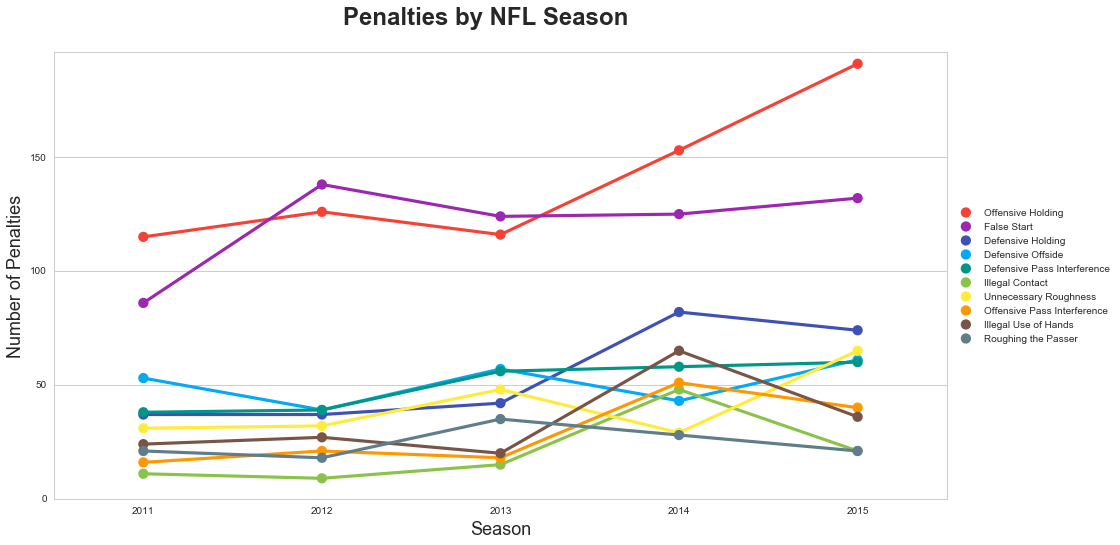

In [8]:
g = fp.groupby(['Season','Penalty'], as_index = False).count()
h = g.sort_values(['Player'], ascending = False)[['Season','Penalty','Team']]
cPens = h.Penalty.unique()[0:10]
h = h[h['Penalty'].isin(cPens)] 
h['NumPenalties'] = h['Team']

fig = plt.figure(figsize=(16, 8))
fig.suptitle('Penalties by NFL Season', fontsize=24, fontweight='bold')

ax = sns.pointplot(x = 'Season', y = 'NumPenalties', hue = 'Penalty', data=h)
plt.xlabel('Season', fontsize=18)
plt.ylabel('Number of Penalties', fontsize=18)

ax.set_ylim([0,int(max(h.NumPenalties) + 5)])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Exploratory analysis 1b: Who was getting all those offensive holding penalties last year?

         Player  Penalty  Season
35      A.Smith       33    2014
340    J.Thomas       18    2015
610     T.Smith       16    2011
182    D.Walker       15    2013
575     S.Smith       12    2011
576     S.Smith       12    2012
230     J.Allen       12    2012
220  G.Robinson       12    2015
36      A.Smith       11    2015
100   C.Johnson       11    2011
158     D.Jones       10    2012
160     D.Jones       10    2015
564   S.Johnson       10    2013
159     D.Jones       10    2014
66      B.Jones       10    2014


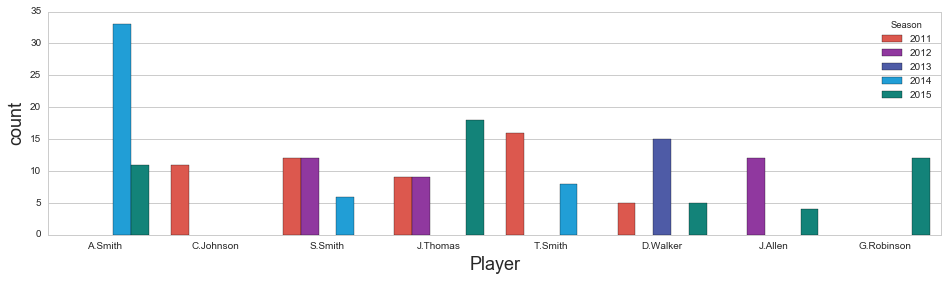

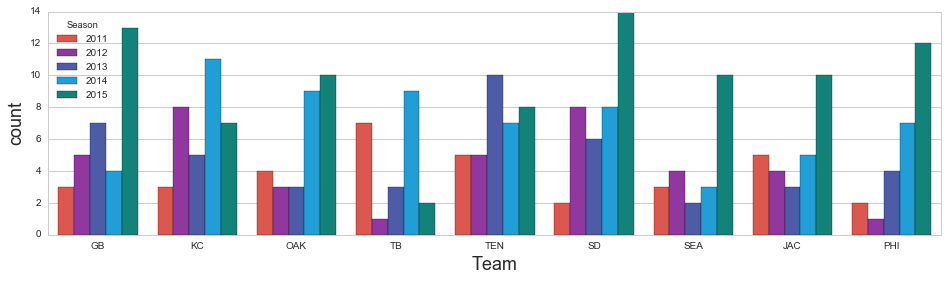

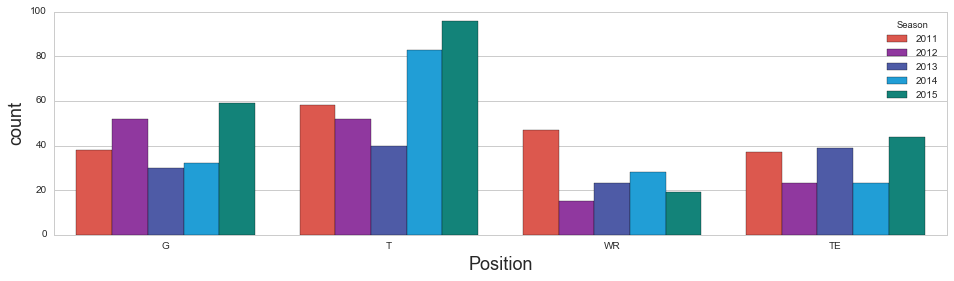

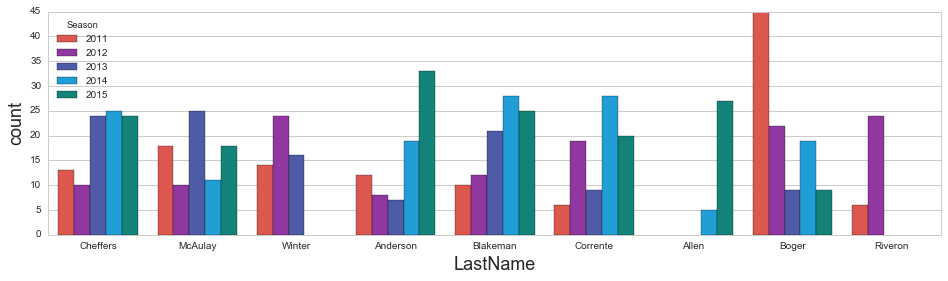

In [10]:
i = fp[(fp['Penalty'] == 'Offensive Holding')]

#Check by player, team, position, ref
for gVar in ['Player','Team','Position','LastName']:
    fig = plt.figure(figsize=(16, 4))
    fig.suptitle = str('Offensive Holding Penalties vs. ' + str(gVar))
    j = i.groupby([gVar, 'Season'], as_index = False).count()
    k = j.sort_values(['Penalty'], ascending = False)[[gVar,'Penalty','Season']]
    if (gVar == 'Player'):
        print k.head(15)
    top10 = k.head(10)[gVar]
    l = i[i[gVar].isin(top10)]
    ax = sns.countplot(x = str(gVar), hue = 'Season', data = l)
    plt.xlabel(str(gVar), fontsize=18)
    plt.ylabel('count', fontsize=18)
    
    

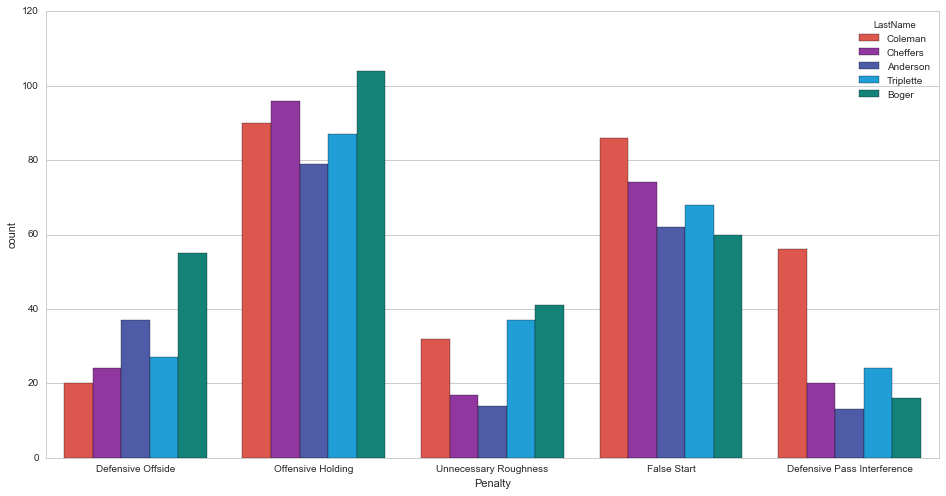

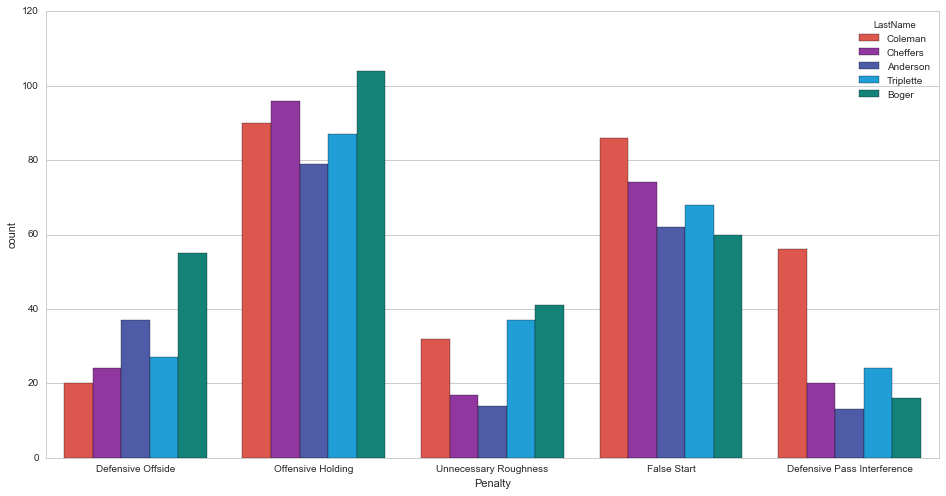

In [13]:
m = fp

for gVar in ['LastName','Penalty']:
    j = m.groupby([gVar], as_index = False).count()
    v = m.groupby([gVar], as_index = False).count()
    k = j.sort_values(['Team'], ascending = False)[[gVar,'Team']]
    top10 = k.head(5)[gVar]
    m = m[m[gVar].isin(top10)]

fig = plt.figure(figsize=(16, 8))
fig.suptitle = str('Penalties by Referee')
ax = sns.countplot(x = 'Penalty', hue = 'LastName', data = m)


for gVar in ['LastName','Penalty']:
    j = m.groupby([gVar], as_index = False).count()
    v = m.groupby([gVar], as_index = False).count()
    k = j.sort_values(['Team'], ascending = False)[[gVar,'Team']]
    top10 = k.head(8)[gVar]
    m = m[m[gVar].isin(top10)]

fig = plt.figure(figsize=(16, 8))
fig.suptitle = str('Penalties by Referee')
ax = sns.countplot(x = 'Penalty', hue = 'LastName', data = m)


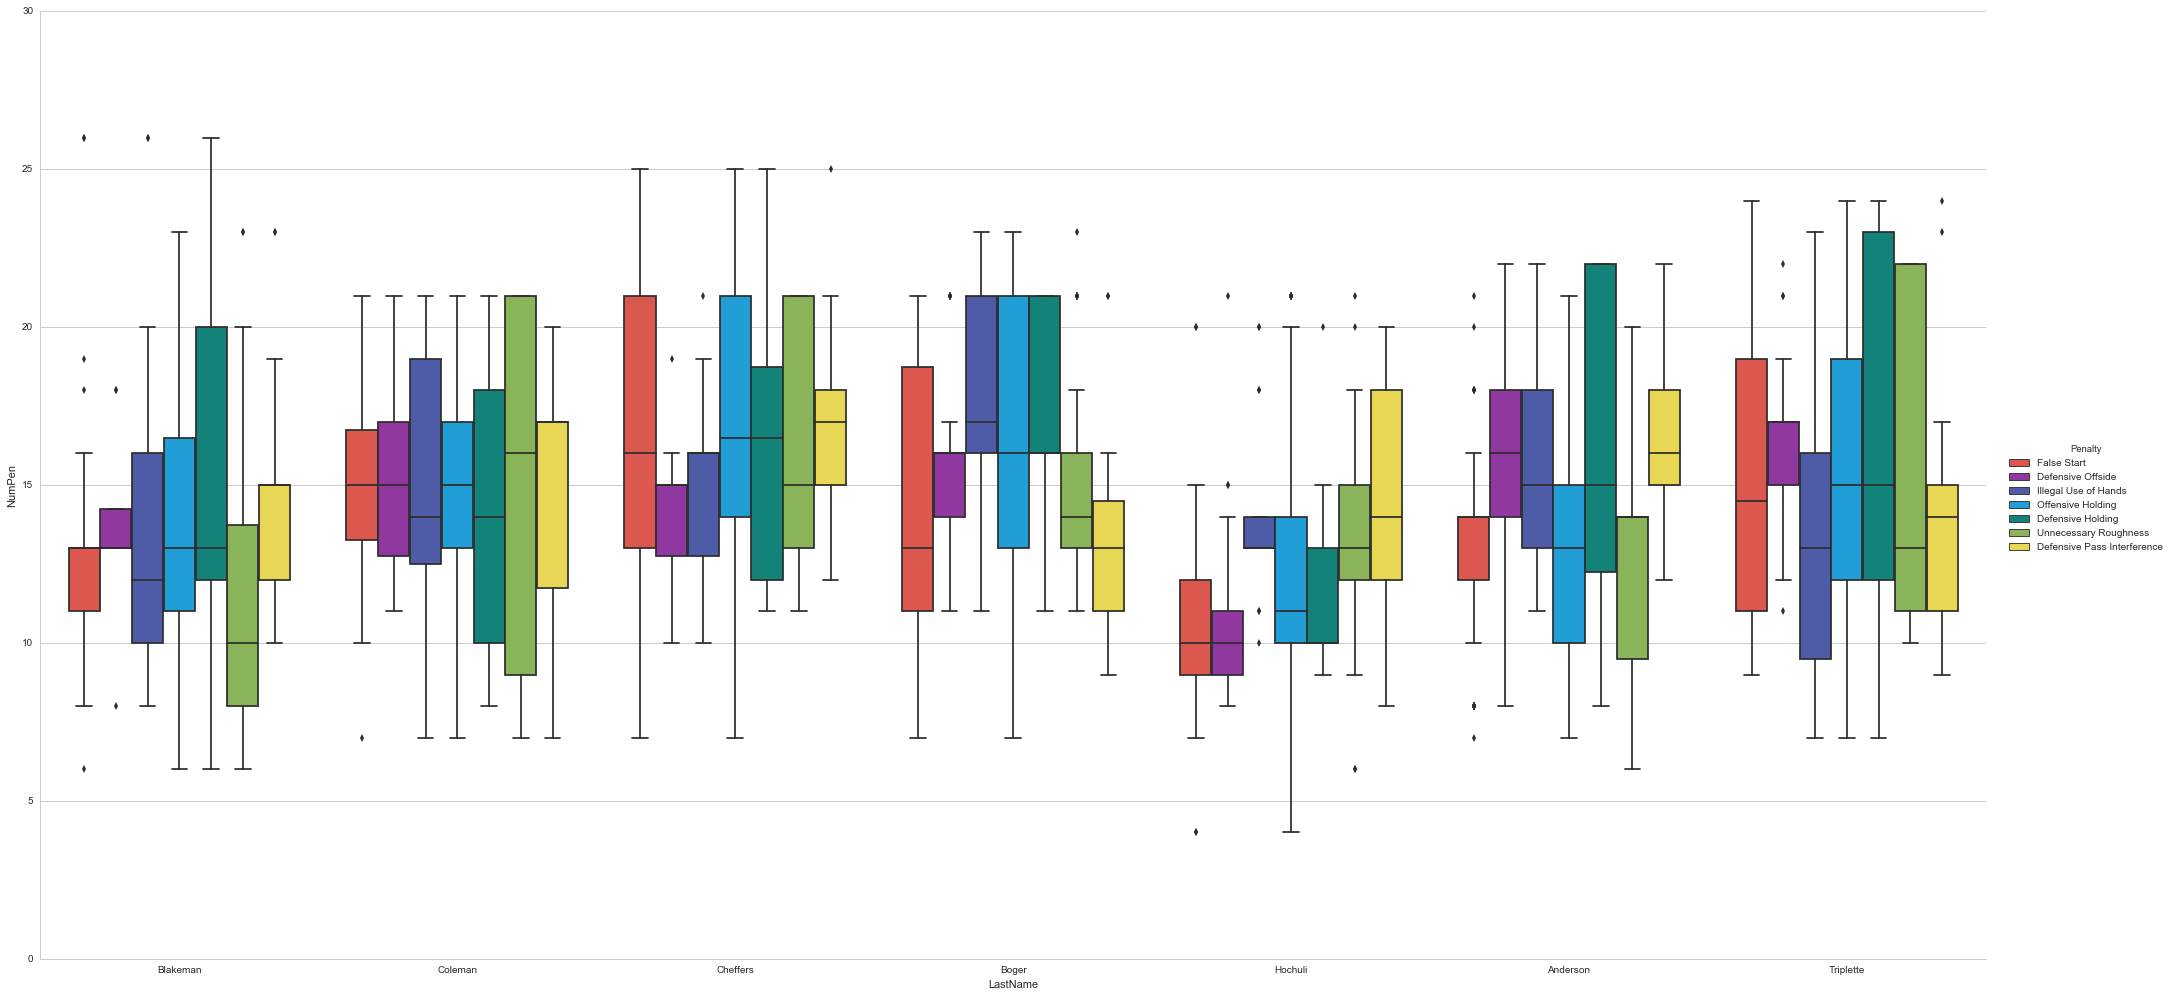

In [14]:
m = fp
m['NumPen'] = m['HPen'] + m['VPen']

for gVar in ['LastName','Penalty']:
    j = m.groupby([gVar], as_index = False).count()
    k = j.sort_values(['Team'], ascending = False)[[gVar,'Team']]
    top10 = k.head(7)[gVar]
    m = m[m[gVar].isin(top10)]
    
fig = plt.figure(figsize=(8, 16))
ax = sns.factorplot(x="LastName", y="NumPen", hue = 'Penalty', data=m, kind="box", aspect = 2, size = 14)

In [ ]:
#Machine learning: Given team and ref, predict penalty rate